# Today you are an MLE in the Personalization Department in Macy's cosmetics!
Your goal is to predict outcomes of online browsing sessions, namely predicting if the next sequence of events/session will result in a purchase or not. 

Models used in this assignment are similar to https://github.com/guillaume-chevalier/seq2seq-signal-prediction/blob/master/seq2seq.ipynb



# Task 0: Getting familiar with the Data

...if you're in Colab...

In [5]:
#Mount the RAW session level data: shopping.pkl
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Import all libraries
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Bidirectional

In [7]:
#Read and look at the RAW data
data = pd.read_pickle('/content/drive/MyDrive/Notebooks/Sequence_Models/shopping.pkl') # This is where I stored my data. Where'd you put yours?
print('Shape of data=', data.shape)
data.head()

Shape of data= (1500000, 12)


,event_time,event_type,product_id,category_id,brand,price,user_id,user_session,year,month,weekday,hour
0,2019-12-01 00:00:00,remove_from_cart,5712790,1487580005268456287,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,2019,12,Sunday,0
1,2019-12-01 00:00:00,view,5764655,1487580005411062629,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18,2019,12,Sunday,0
2,2019-12-01 00:00:02,cart,4958,1487580009471148064,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,2019,12,Sunday,0
3,2019-12-01 00:00:05,view,5848413,1487580007675986893,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4,2019,12,Sunday,0
4,2019-12-01 00:00:07,view,5824148,1487580005511725929,nan,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5,2019,12,Sunday,0


So, for each unique user_session ID, the data fields that are collected are the time the event occured, the type of event (view, cart, remove, purchase), the product ID, category ID, brand, price, user ID, year, month, weekday, and hour. Notice that we have 1.5M data samples.

# Task 1: Set up and train a simple RNN on this time series data

There's a lot of data we could use here, but we're going to start with something pretty simple. Think of a user session as being made up of a series of events (e.g. ['view', (add to)'cart', 'view', (add to)'cart', 'purchase']). We want a model that can take in a series of non-purchase events, and predict whether a purchase is going to occur. In the example above, ['view', (add to)'cart', 'view', (add to)'cart'] is a **sequence** which culminates in a purchase. We'll create a representation of sequences of events, and train a model to predict whether or not a purchase is going to occur. 

This work is the modification from the paper: https://arxiv.org/ftp/arxiv/papers/2010/2010.02503.pdf

## Step 1: Create sequence data for each session

In [8]:
# Convert the event types to numeric values
events = {'purchase':1,'cart': 2,'view': 3, 'remove_from_cart':4}
data['event'] = data.event_type.map(events)

In [9]:
# Sort the events by 'event_time'
data = data.sort_values('event_time')
data.head()

,event_time,event_type,product_id,category_id,brand,price,user_id,user_session,year,month,weekday,hour,event
0,2019-12-01 00:00:00,remove_from_cart,5712790,1487580005268456287,f.o.x,6.27,576802932,51d85cb0-897f-48d2-918b-ad63965c12dc,2019,12,Sunday,0,4
1,2019-12-01 00:00:00,view,5764655,1487580005411062629,cnd,29.05,412120092,8adff31e-2051-4894-9758-224bfa8aec18,2019,12,Sunday,0,3
2,2019-12-01 00:00:02,cart,4958,1487580009471148064,runail,1.19,494077766,c99a50e8-2fac-4c4d-89ec-41c05f114554,2019,12,Sunday,0,2
3,2019-12-01 00:00:05,view,5848413,1487580007675986893,freedecor,0.79,348405118,722ffea5-73c0-4924-8e8f-371ff8031af4,2019,12,Sunday,0,3
4,2019-12-01 00:00:07,view,5824148,1487580005511725929,nan,5.56,576005683,28172809-7e4a-45ce-bab0-5efa90117cd5,2019,12,Sunday,0,3


^ The `event` column we added is just a numerical representation of the of the event type (purchase, cart, view, remove_from_cart)

Next, process the data into a new dataframe `sequence`, to have three columns:
1. There will still be a `user_session` column, but now only one row for each user session
2. The `event` column will now be a list of the events that occured in that session, in the order they occured. 
3. A `purchase` column indicates whether the events for that session included a purchase. The number 1 will indicate a purchase, 0 will indicate no purchase.

In [10]:
sequence = data.groupby('user_session')['event'].apply(list)
sequence = sequence.reset_index()
sequence['purchase'] = sequence['event'].apply(lambda x: 1 if 1 in x else 0)
sequence = sequence[sequence['event'].map(len)> 1]

In [11]:
sequence.head()

,user_session,event,purchase
2,00018d32-afba-4db8-9d3d-562c83580579,"[3, 2]",0
4,0001d956-e104-487b-a045-3864d7b9a022,"[2, 2, 2, 2, 2, 2, 2]",0
5,0001ebd4-441d-4c2f-a888-929a63b2afe3,"[3, 3, 3, 3, 3, 3, 3, 3]",0
7,00027027-c51e-4b8f-82bc-0122b3d44204,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, ...",0
9,0002b72e-c9b0-4b2e-99c8-a6c8630c4cfe,"[2, 3, 2, 2, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, ...",0


...one problem we have is that the event entries still have '1's for the purchase events, let's get rid of those because their presence is already indicated by the purchase column... 

In [12]:
#The sequence data should not contain the "purchase field" so it is filtered out
sequence['event']= sequence.event.apply(lambda row: list(filter(lambda a: a != 1, row)))
print('Total number of records=', sequence.shape[0])
sequence.head()

Total number of records= 119480


,user_session,event,purchase
2,00018d32-afba-4db8-9d3d-562c83580579,"[3, 2]",0
4,0001d956-e104-487b-a045-3864d7b9a022,"[2, 2, 2, 2, 2, 2, 2]",0
5,0001ebd4-441d-4c2f-a888-929a63b2afe3,"[3, 3, 3, 3, 3, 3, 3, 3]",0
7,00027027-c51e-4b8f-82bc-0122b3d44204,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 3, ...",0
9,0002b72e-c9b0-4b2e-99c8-a6c8630c4cfe,"[2, 3, 2, 2, 4, 4, 4, 4, 4, 4, 3, 3, 3, 4, 4, ...",0


In [13]:
temp_one_hot = np.array(pd.get_dummies(sequence['purchase'],prefix='Purchase'))
fraction_with_purchase=np.sum(temp_one_hot[:,1])/len(temp_one_hot)
print('Fraction of sessions ending in a purchase:', fraction_with_purchase)

Fraction of sessions ending in a purchase: 0.09381486441245397


What does an average sequence look like? Can some sequences be especially long and others be very short?

In [14]:
#Find the length of events per user-session
length = sequence['event'].map(len).to_list()

In [15]:
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


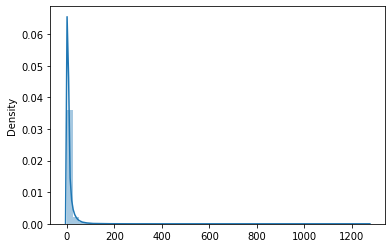

In [16]:
sns.distplot(length)

### So we see that most sequences are about 100 or shorter. 
One difficult task in time series modeling is to find the optimal sequence size for highest prediction accuracy. We won't attemp that today, but let's at least split the data up into short and long sequences, to see if there's a difference in models trained on these different sequence lengths. 
### We'll focus on sequences that have lengths less than or equal to 10.

In [17]:
# select all sequences that are upto 10 events long. Discard remaining sequences.
short_sequence_10 = sequence[sequence['event'].map(len) <= 10]

In [18]:
#Lets see how many records come up
short_sequence_10

,user_session,event,purchase
2,00018d32-afba-4db8-9d3d-562c83580579,"[3, 2]",0
4,0001d956-e104-487b-a045-3864d7b9a022,"[2, 2, 2, 2, 2, 2, 2]",0
5,0001ebd4-441d-4c2f-a888-929a63b2afe3,"[3, 3, 3, 3, 3, 3, 3, 3]",0
10,0002ba44-8b73-4ace-b7c8-fe946aa63cc2,"[3, 2, 2]",0
17,0003d895-8dd0-47c2-94e0-92f7a9031c74,"[3, 3]",0
...,...,...,...
336954,fffb5277-899a-46d8-b51e-2c1f61880f4e,"[3, 2]",0
336963,fffcec5a-c2e3-4e13-8f40-a63f7d14c81f,"[4, 4]",0
336965,fffd3d91-5734-42ac-b149-7403417ec3e2,"[3, 3, 3, 3, 3]",0
336966,fffd5100-6389-486d-8732-9066c47f7ba1,"[3, 3, 2, 3, 3]",0


Let's do a little more preprocessing to arrange this data in a form amenable to training a TensorFlow neural network...

In [19]:
event_sequence = short_sequence_10['event'].to_list()

In [20]:
event_sequence[0:10]

[[3, 2],
 [2, 2, 2, 2, 2, 2, 2],
 [3, 3, 3, 3, 3, 3, 3, 3],
 [3, 2, 2],
 [3, 3],
 [3, 2],
 [3, 3, 3, 3, 3],
 [2, 2, 2, 2, 2, 4, 4],
 [3, 3, 3],
 [3, 3]]

In [21]:
# Pad all sequences with zeros so all inputs have same consistent size of 10
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
event = pad_sequences(event_sequence)

In [22]:
event[0:10]

array([[0, 0, 0, 0, 0, 0, 0, 0, 3, 2],
       [0, 0, 0, 2, 2, 2, 2, 2, 2, 2],
       [0, 0, 3, 3, 3, 3, 3, 3, 3, 3],
       [0, 0, 0, 0, 0, 0, 0, 3, 2, 2],
       [0, 0, 0, 0, 0, 0, 0, 0, 3, 3],
       [0, 0, 0, 0, 0, 0, 0, 0, 3, 2],
       [0, 0, 0, 0, 0, 3, 3, 3, 3, 3],
       [0, 0, 0, 2, 2, 2, 2, 2, 4, 4],
       [0, 0, 0, 0, 0, 0, 0, 3, 3, 3],
       [0, 0, 0, 0, 0, 0, 0, 0, 3, 3]], dtype=int32)

In [23]:
# One Hot Encoding the Purchase label
y = np.array(pd.get_dummies(short_sequence_10['purchase'],prefix='Purchase'))
z=np.sum(y[:,1])/len(y)
print('Fraction of purchase sessions for the length-10 sequence data:',z)

Fraction of purchase sessions for the length-10 sequence data: 0.06487488415199258


In [24]:
#Define a function to generate 70/30 data split followed by data resizing
def prepare_train_test_data(data,y):
  #input is data[nxd] and Y[nx2], outputs 70/30 split formatted for the sequence models
  X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3)
  #Resizing is necessary since input to Tensorflow sequence models is (1,d)
  X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
  X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
  return (X_train,X_test,y_train,y_test)

In [25]:
X_train, X_test, y_train, y_test=prepare_train_test_data(np.array(event),y)
print(X_train.shape, y_train.shape)

(64200, 1, 10) (64200, 2)


These helper functions below are just used to display model accuracy during training, and also evaluate the performance of a trained model:

In [26]:
import matplotlib.pyplot as plt

# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


def plot_history(history):
  # This function will plot the model fit process
  print(history.history.keys())
  # summarize history for accuracy
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  plt.title('model accuracy')
  plt.ylabel('acc')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()


def evaluate_on_test(X_test, y_test, training_model):
  #This function will evaluate the fit model on test data
  model_output=training_model.predict(X_test)
  g_preds = np.argmax(model_output,axis=1)
  gaccuracy = accuracy_score(y_test[:,1], g_preds)
  print('Accuracy: %f' % gaccuracy)
  # precision tp / (tp + fp)
  gprecision = precision_score(y_test[:,1], g_preds)
  print('Precision: %f' % gprecision)
  # recall: tp / (tp + fn)
  grecall = recall_score(y_test[:,1], g_preds)
  print('Recall: %f' % grecall)
  # f1: 2 tp / (2 tp + fp + fn)
  gf1 = f1_score(y_test[:,1], g_preds)
  print('F1 score: %f' % gf1)


We'll start with training a [`SimpleRNN`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) and then move on to fancier things.

In [27]:
from tensorflow.keras.layers import GRU, Embedding, SimpleRNN, Activation
import tensorflow as tf

In [28]:
#This is a simple RNN model
def simple_RNN_model(neurons=40, op=10):
    model = Sequential()
    model.add(SimpleRNN(neurons, return_sequences = True, input_shape = (1,op))) ##neurons: units (layer output shape), op: input vector size = sequence length
    model.add(SimpleRNN(2*neurons))
    model.add(Dense(2, activation='softmax'))
    model.compile(
      optimizer=tf.optimizers.Adam(learning_rate=0.0003),
      loss='binary_crossentropy',
      metrics=['acc'])
    return model

In [29]:
#Visualize the Model
tf.keras.backend.clear_session()
RNN_model = simple_RNN_model(neurons=40, op=10)
RNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 1, 40)             2040      
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 80)                9680      
_________________________________________________________________
dense (Dense)                (None, 2)                 162       
Total params: 11,882
Trainable params: 11,882
Non-trainable params: 0
_________________________________________________________________


In [30]:
#Fit the model using 80/20 validation split at runtime
r_history = RNN_model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=1000,
                    validation_split=0.2)

Epoch 1/20
52/52 [==============================] - 5s 18ms/step - loss: 0.4088 - acc: 0.9139 - val_loss: 0.2491 - val_acc: 0.9350
Epoch 2/20
52/52 [==============================] - 1s 11ms/step - loss: 0.2222 - acc: 0.9353 - val_loss: 0.2116 - val_acc: 0.9350
Epoch 3/20
52/52 [==============================] - 1s 11ms/step - loss: 0.2072 - acc: 0.9353 - val_loss: 0.2070 - val_acc: 0.9350
Epoch 4/20
52/52 [==============================] - 1s 10ms/step - loss: 0.2040 - acc: 0.9353 - val_loss: 0.2046 - val_acc: 0.9350
Epoch 5/20
52/52 [==============================] - 1s 10ms/step - loss: 0.2020 - acc: 0.9353 - val_loss: 0.2028 - val_acc: 0.9350
Epoch 6/20
52/52 [==============================] - 1s 10ms/step - loss: 0.2002 - acc: 0.9353 - val_loss: 0.2011 - val_acc: 0.9350
Epoch 7/20
52/52 [==============================] - 1s 11ms/step - loss: 0.1985 - acc: 0.9456 - val_loss: 0.1994 - val_acc: 0.9452
Epoch 8/20
52/52 [==============================] - 1s 11ms/step - loss: 0.1969 - a

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


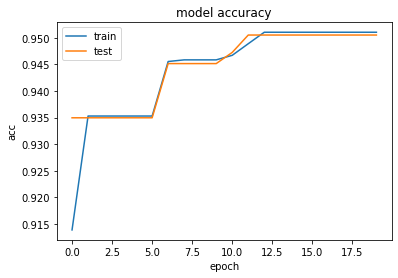

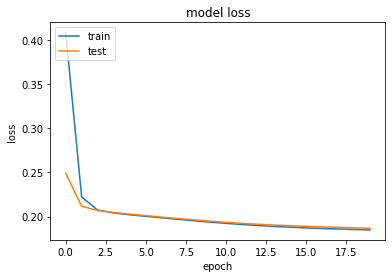

In [31]:
plot_history(r_history)

In [32]:
evaluate_on_test(X_test,y_test,RNN_model)

Accuracy: 0.951408
Precision: 1.000000
Recall: 0.253906
F1 score: 0.404984


Okay, so that was pretty straightforward--we preprocessed the data to have numerical sequences of length 10 (corresponding to different online shoping events), and then used a model with two SimpleRNN layers from TensorFlow to train on this data. The recall here is fairly low, ostensibly because of the imbalance of purchase and non-purchase events, but this was a good first start.

# Task 2: Train GRU-based and LSTM-based models on the length-10 sequence data.


Define a network based on GRU layers called `GRU_model`. Just copy and paste the architecture of `simple_RNN_model` and exchange the `SimpleRNN` layers for `GRU` layers (these have already been imported above).

In [33]:
def GRU_model(neurons=40, op=10):
  model = Sequential()
  ############### START CODE HERE ################
  #This is a simple RNN model
  model.add(GRU(neurons, return_sequences = True, input_shape = (1,op))) ##neurons: units (layer output shape), op: input vector size = sequence length
  model.add(GRU(2*neurons))
  model.add(Dense(2, activation='softmax'))
  model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0003),
    loss='binary_crossentropy',
    metrics=['acc'])
  return model
  ####### END CODE HERE #######

In [34]:
#Visualize the Model
tf.keras.backend.clear_session()
G_model = GRU_model()
G_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 40)             6240      
_________________________________________________________________
gru_1 (GRU)                  (None, 80)                29280     
_________________________________________________________________
dense (Dense)                (None, 2)                 162       
Total params: 35,682
Trainable params: 35,682
Non-trainable params: 0
_________________________________________________________________


^ Note the increase in the number of parameters.

In [35]:
#Train the G_model (40 epochs, 1000 samples per batch, validation split=0.2)
g_history = G_model.fit(X_train, y_train,
                        epochs=20,
                        batch_size=1000,
                        validation_split=0.2)

Epoch 1/20
52/52 [==============================] - 7s 23ms/step - loss: 0.5861 - acc: 0.9041 - val_loss: 0.4564 - val_acc: 0.9350
Epoch 2/20
52/52 [==============================] - 0s 8ms/step - loss: 0.3428 - acc: 0.9353 - val_loss: 0.2574 - val_acc: 0.9350
Epoch 3/20
52/52 [==============================] - 0s 8ms/step - loss: 0.2337 - acc: 0.9353 - val_loss: 0.2216 - val_acc: 0.9350
Epoch 4/20
52/52 [==============================] - 0s 8ms/step - loss: 0.2154 - acc: 0.9353 - val_loss: 0.2125 - val_acc: 0.9350
Epoch 5/20
52/52 [==============================] - 0s 7ms/step - loss: 0.2093 - acc: 0.9353 - val_loss: 0.2092 - val_acc: 0.9350
Epoch 6/20
52/52 [==============================] - 0s 8ms/step - loss: 0.2069 - acc: 0.9353 - val_loss: 0.2076 - val_acc: 0.9350
Epoch 7/20
52/52 [==============================] - 0s 8ms/step - loss: 0.2056 - acc: 0.9353 - val_loss: 0.2064 - val_acc: 0.9350
Epoch 8/20
52/52 [==============================] - 0s 8ms/step - loss: 0.2045 - acc: 0.9

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


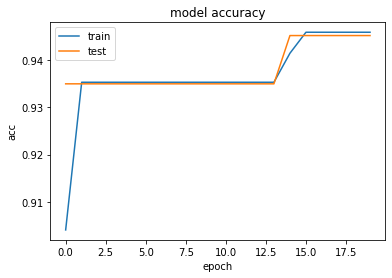

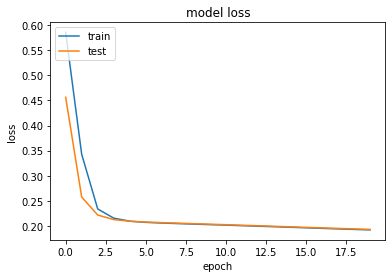

In [36]:
#Use plot_history function to plot the model curves for loss and accuracy
plot_history(g_history)

In [37]:
# Use evaluate_on_test function to note accuracy, precision, recall and F1 score on test data
evaluate_on_test(X_test,y_test, G_model)

Accuracy: 0.945593
Precision: 1.000000
Recall: 0.164621
F1 score: 0.282702


These may get a very similar performance as the simple RNN, but you can check that it does produce slightly different outputs. GRU recurrent neural networks are just a more complicated type of network and often perform better on sequence prediction tasks. 

Do the same as you did above for GRU, but this time for a model based on [`LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layers. Try wrapping the first LSTM layer with [`Bidirectional`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional).



In [64]:
#Define an LSTM model function. Use the LSTM layer as shown below.
#Notice the change in number of parameters
def LSTM_model(neurons=40, op=10):
  model = Sequential()
  #model.add(Bidirectional(LSTM(neurons, return_sequences = True, input_shape = (1,op)))) ##neurons: units (layer output shape), op: input vector size = sequence length
  model.add(Bidirectional(LSTM(40, return_sequences=True), input_shape=(1, 10)))
  model.add(LSTM(2*neurons))
  model.add(Dense(2, activation='softmax'))
  model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0003),
    loss='binary_crossentropy',
    metrics=['acc'])
  #### END CODE HERE #####
  return model

In [65]:
tf.keras.backend.clear_session()
l_model = LSTM_model(neurons=40, op=10)
l_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 1, 80)             16320     
_________________________________________________________________
lstm_1 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dense (Dense)                (None, 2)                 162       
Total params: 68,002
Trainable params: 68,002
Non-trainable params: 0
_________________________________________________________________


In [66]:
#Train the training_model (20 epochs, 1000 samples per batch, validation split=0.2)
l_history = l_model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=1000,#atleast 1000 records per epoch
                    validation_split=0.2)

Epoch 1/20
52/52 [==============================] - 7s 35ms/step - loss: 0.6409 - acc: 0.8721 - val_loss: 0.5631 - val_acc: 0.9350
Epoch 2/20
52/52 [==============================] - 1s 10ms/step - loss: 0.4399 - acc: 0.9353 - val_loss: 0.3121 - val_acc: 0.9350
Epoch 3/20
52/52 [==============================] - 1s 11ms/step - loss: 0.2597 - acc: 0.9353 - val_loss: 0.2315 - val_acc: 0.9350
Epoch 4/20
52/52 [==============================] - 1s 11ms/step - loss: 0.2200 - acc: 0.9353 - val_loss: 0.2133 - val_acc: 0.9350
Epoch 5/20
52/52 [==============================] - 1s 11ms/step - loss: 0.2087 - acc: 0.9353 - val_loss: 0.2074 - val_acc: 0.9350
Epoch 6/20
52/52 [==============================] - 1s 11ms/step - loss: 0.2049 - acc: 0.9353 - val_loss: 0.2049 - val_acc: 0.9350
Epoch 7/20
52/52 [==============================] - 1s 11ms/step - loss: 0.2031 - acc: 0.9353 - val_loss: 0.2034 - val_acc: 0.9350
Epoch 8/20
52/52 [==============================] - 1s 11ms/step - loss: 0.2018 - a

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


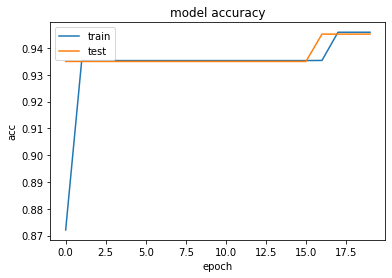

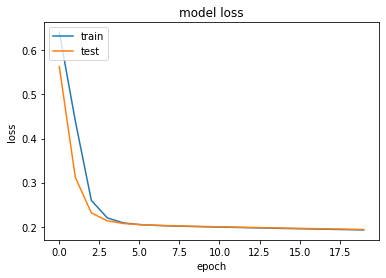

In [67]:
#Use plot_history function to plot the model curves for loss and accuracy
plot_history(l_history)

In [68]:
# Use evaluate_on_test function to note accuracy, precision, recall and F1 score on test data
evaluate_on_test(X_test,y_test,l_model)

Accuracy: 0.945593
Precision: 1.000000
Recall: 0.164621
F1 score: 0.282702


...LSTMs can sometimes take longer to fit because they have more free parameters.

# Task 3: Let's try running the GRU model on a different dataset with more informative features.

In [69]:
#Next lets look at some other session "features"
feat = pd.read_pickle('/content/drive/MyDrive/Notebooks/Sequence_Models/Session_features.pkl')
print('Shape of data=', feat.shape)
feat.head()

Shape of data= (1500000, 36)


,TotalEventsInSession,interactionTime,#TimesCartedinSession,#TimesViewedinSession,maxPrice,minPrice,AvgAmtCartedInSession,AvgAmtViewedInSession,#BrandsCartedInSession,#BrandsViewedInSession,#CategoriesCartedInSession,#CategoriesViewedInSession,OverallAmtUserCarted,OverallAmtUserViewed,#ProdsCartedInSession,#ProdsViewedInSession,Fr,Mon,Sat,Sun,Thu,Tue,Wed,2019,Nov,Oct,Sep,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Noon,Weekend,Purchase
0,7,493.0,0,7,1349.46,131.53,0.00,812.941429,0,7,0,7,145.095000,187.166429,0,7,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0
1,18,585.0,1,16,1747.79,152.58,289.52,621.671250,1,16,1,16,461.202273,653.235432,1,16,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1
2,1,0.0,0,1,1422.10,1422.10,0.00,1422.100000,0,1,0,1,0.000000,625.779478,0,1,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0
3,1,0.0,0,1,308.63,308.63,0.00,308.630000,0,1,0,1,0.000000,609.110000,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0
4,11,509.0,4,6,171.90,131.51,171.90,158.220000,4,6,4,6,153.899000,150.426207,4,6,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1


This is just a different dataset that's focused on whole sessions, for which we have more different types of features (36 of them)

Suppose we were to treat each row of features as a "sequence." This is not the most common setup for RNNs, (since each element in the sequence (each column) represents different types of quantities) but it'll work in our case. We'll take the first 35 columns as the elements of our sequence and the 36th column, the purchase column, as the target:

In [70]:
Xf=feat.iloc[:,0:35]
Yf=feat.iloc[:,35]
yf = np.array(pd.get_dummies(Yf, prefix='Purchase'))
Xf_train, Xf_test, yf_train, yf_test=prepare_train_test_data(np.array(Xf), np.array(yf)) # Function call to 'prepare_train_test_data' to create 70/30 split data
print(Xf_train.shape, yf_train.shape)

(1050000, 1, 35) (1050000, 2)


In [71]:
#Initialize ANY model (RNN or GRU or LSTM)
def GRU_model(neurons=40, op=10):
  model = Sequential()
  model.add(GRU(neurons, return_sequences = True, input_shape = (1,op)))
  model.add(GRU(2*neurons))
  model.add(Dense(2, activation='softmax'))
  model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0003),
    loss='binary_crossentropy',
    metrics=['acc'])
  return model

#Visualize the Model (Notice the increase in parameters)
tf.keras.backend.clear_session()
gru_model = GRU_model(neurons=40, op=Xf_train.shape[2])
gru_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 1, 40)             9240      
_________________________________________________________________
gru_1 (GRU)                  (None, 80)                29280     
_________________________________________________________________
dense (Dense)                (None, 2)                 162       
Total params: 38,682
Trainable params: 38,682
Non-trainable params: 0
_________________________________________________________________


In [72]:
#Fit your model on Training data (20 epochs, 1000 samples per batch, validation_split=0.2)
gru_history = gru_model.fit(Xf_train, yf_train,
                    epochs=20,
                    batch_size=1000,#atleast 1000 records per epoch
                    validation_split=0.2)

Epoch 1/20
840/840 [==============================] - 8s 7ms/step - loss: 0.2016 - acc: 0.9231 - val_loss: 0.1564 - val_acc: 0.9362
Epoch 2/20
840/840 [==============================] - 5s 6ms/step - loss: 0.1499 - acc: 0.9376 - val_loss: 0.1459 - val_acc: 0.9387
Epoch 3/20
840/840 [==============================] - 5s 6ms/step - loss: 0.1410 - acc: 0.9395 - val_loss: 0.1387 - val_acc: 0.9402
Epoch 4/20
840/840 [==============================] - 5s 6ms/step - loss: 0.1341 - acc: 0.9414 - val_loss: 0.1305 - val_acc: 0.9428
Epoch 5/20
840/840 [==============================] - 5s 6ms/step - loss: 0.1285 - acc: 0.9432 - val_loss: 0.1264 - val_acc: 0.9445
Epoch 6/20
840/840 [==============================] - 5s 6ms/step - loss: 0.1219 - acc: 0.9457 - val_loss: 0.1186 - val_acc: 0.9487
Epoch 7/20
840/840 [==============================] - 5s 6ms/step - loss: 0.1144 - acc: 0.9497 - val_loss: 0.1112 - val_acc: 0.9527
Epoch 8/20
840/840 [==============================] - 5s 6ms/step - loss: 0.

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


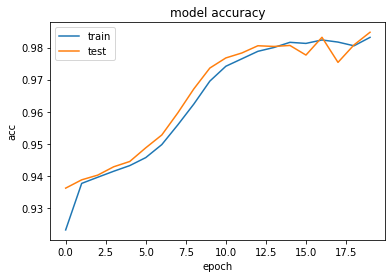

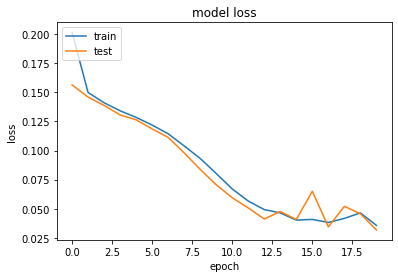

In [73]:
#Use plot_history function to plot the model curves for loss and accuracy
plot_history(gru_history)

In [74]:
# Use evaluate_on_test function to note accuracy, precision, recall and F1 score on test data
evaluate_on_test(Xf_test,yf_test,gru_model)

Accuracy: 0.984542
Precision: 0.929098
Recall: 0.841998
F1 score: 0.883406


#Comment on what you would suggest to your manager?


*  Is feature-level data necessary? What metrics suggest that?
*  What you you suggest to improve the quality of the model trained on event-sequence data (the first dataset?) 



1. Yes it is important the feature-level data because the whole model is focus on below 10 which make it limited to the data available. I think generalizing to the whole dataset may have lower performance but wide range of insights to predict. Generalizing for the whole dataframe may be difficult, however non-linearity learning will perform correctly in case that a RNN is used.  
2. I'd suggest to work with GRU due the higher performance compare to LSTM and simple RNN. LSTM takes longer and might be too old fashioned model, simple RNN is good but not great and GRU have accomplish the expectations. 